In [1]:
%matplotlib notebook
from ase.io import read
from ase.io import write
from ase import Atoms
from ase.build import surface
from ase.build import fcc100
from ase.build import fcc110
from ase.build import fcc111
from ase.build import bulk
from matplotlib import pyplot as plt
from abtem import show_atoms
import abtem
import numpy as np
from skimage.measure import label
from math import isqrt
import hyperspy.api as hs

## Make segmented space as microstructure

In [2]:
specimen = np.zeros((200, 200, 100), dtype=int)
specimen_coords = np.asarray(np.where(specimen == 0)).T

In [3]:
specimen_thickness = 0.75 #fractional_thickness

In [4]:
specimen[:,:,:int(specimen.shape[2] * specimen_thickness)] = 1

In [5]:
def view_specimen(specimen, sampling = (8,8,2), alpha = 0.15, s = 1):
    specimen_coords = np.asarray(np.where(specimen != -1)).T
    sc_shape = list(specimen.shape) + [3]

    specimen_coords = specimen_coords.reshape(sc_shape)
    specimen_coords = specimen_coords[::sampling[0], ::sampling[1], ::sampling[2]]
    specimen_coords = specimen_coords.reshape((specimen_coords[:,:,:,0].size, 3))
    
    flat_spec = specimen[::sampling[0], ::sampling[1], ::sampling[2]].reshape(-1)
    
    for uind in np.unique(specimen):
        phase_coords = specimen_coords[np.where(flat_spec == uind)]
        not_phase_coords = specimen_coords[np.where(flat_spec != uind)]
        
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        ax.scatter(phase_coords[:,0], phase_coords[:,1], phase_coords[:,2], 
                   s = s)
        ax.scatter(not_phase_coords[:,0], not_phase_coords[:,1], not_phase_coords[:,2], 
                   s = s, alpha = alpha)
        ax.set_title(f'Phase: {uind}')
    

In [6]:
import copy

In [7]:
def alter_below_plane(specimen, normal, point, ind_to, inds_from):
    '''
    Will change all the voxel indices that match those specified in `inds_from` and are
    below the plane defined by `normal` and `point` to voxel index `ind_to`
    
    e.g. we start with a specimen which is a 3d array (X,Y,Z) of zeros.
    If we specify the plane with normal (0,0,1) {a plane parallel to the x,y plane} that 
    goes through point (50,50,50) and ind_from as 0 {all values of 0 will change} and ind_to 
    as 1. We will get returned a 3d array where all the values of [X,Y,:50] are 1 and everything else
    remains 0
    
    specimen: (3D array)
    normal: (3 value structure) a,b,c values of the surface normal
    point: (3 value structure) x,y,z values of a point on the plane
    ind_to: (ind) The index you want these specified voxels to become
    ind_from: (ind or iterable of inds) The index/indicies you would like to change, if they statisfy 
                the location condition
    '''
    
    new_specimen = copy.deepcopy(specimen)
    
    if type(inds_from) == int:
        inds_from = [inds_from]
        
    if type(inds_from) == type(None):
        inds_from = np.unique(new_specimen)
        print(inds_from)

    a,b,c = normal #surface normal
    x0,y0,z0 = point #point on plane

    mask = np.zeros_like(specimen, dtype=bool)
    for _x in np.arange(specimen.shape[0]):
        for _y in np.arange(specimen.shape[1]):
            for _z in np.arange(specimen.shape[2]):
                if (a * (_x - x0)  + b * (_y - y0) + c * (_z - z0)) <= 0 :
                    mask[_x, _y, _z] = 1
                    
    from_mask = np.sum([np.where(specimen ==i_from, 1, 0) for i_from in inds_from], axis = 0)

    mask = mask*from_mask

    new_specimen[np.where(mask==1)] = ind_to
    
    return new_specimen

def alter_within_sphere(specimen, centre, radius, ind_to, inds_from):
    
    '''
    Will change all the voxel indices that match those specified in `inds_from` and are
    within the sphere defined by `centre` and `radius` to voxel index `ind_to`
    
    
    specimen: (3D array)
    centre: (3 value structure) x,y,z values of a point at the centre of the sphere
    rdaius: (float) radius of the sphere
    ind_to: (ind) The index you want these specified voxels to become
    ind_from: (ind or iterable of inds) The index/indicies you would like to change, if they statisfy 
                the location condition
    '''
    
    new_specimen = copy.deepcopy(specimen)
    
    if type(inds_from) == int:
        inds_from = [inds_from]
        
    if type(inds_from) == type(None):
        inds_from = np.unique(new_specimen)
        print(inds_from)
        
    x0,y0,z0 = centre #point on plane

    mask = np.zeros_like(specimen, dtype=bool)
    for _x in np.arange(specimen.shape[0]):
        for _y in np.arange(specimen.shape[1]):
            for _z in np.arange(specimen.shape[2]):
                if ((_x - x0)**2  + (_y - y0)**2 + (_z - z0)**2) <= radius**2 :
                    mask[_x, _y, _z] = 1
                    
    from_mask = np.sum([np.where(specimen ==i_from, 1, 0) for i_from in inds_from], axis = 0)

    mask = mask*from_mask

    new_specimen[np.where(mask==1)] = ind_to
    
    return new_specimen

In [8]:
norm1 = (2,2,3) #surface normal
p1 = (100,100,50) #point on plane

In [9]:
new_specimen = alter_below_plane(specimen, norm1, p1, 2, 1)

<IPython.core.display.Javascript object>


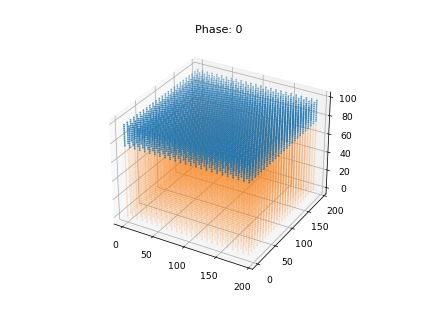

<IPython.core.display.Javascript object>


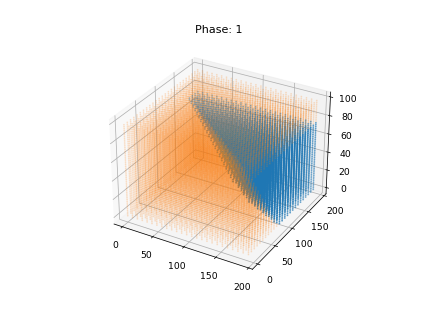

<IPython.core.display.Javascript object>


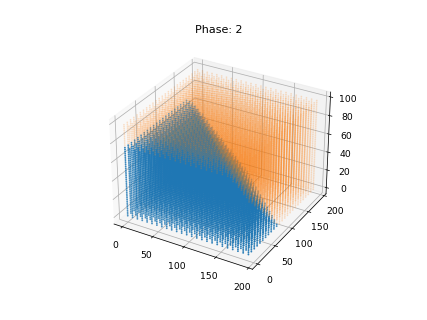

In [10]:
view_specimen(new_specimen, sampling = (8,8,2))

In [11]:
norm2 = (2,1,2) #surface normal
p2 = (90,90,50) #point on plane

new_specimen2 = alter_below_plane(new_specimen, norm2, p2, 3, (1,2))

<IPython.core.display.Javascript object>


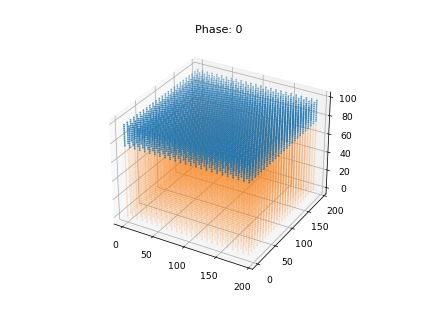

<IPython.core.display.Javascript object>


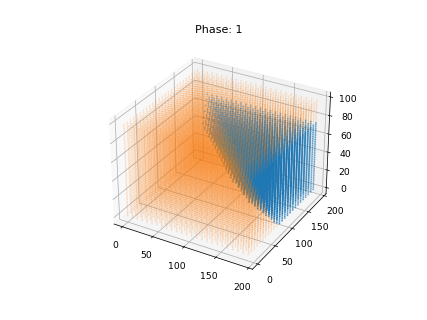

<IPython.core.display.Javascript object>


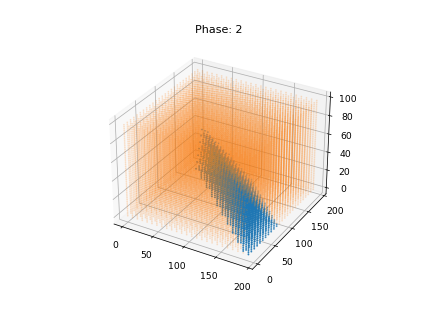

<IPython.core.display.Javascript object>


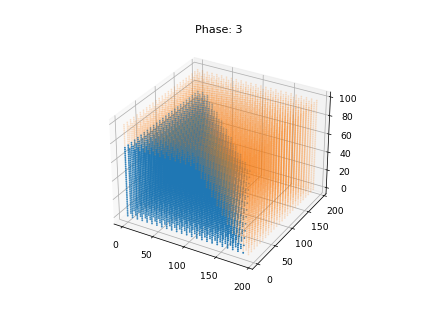

In [12]:
view_specimen(new_specimen2, sampling = (8,8,2))

In [13]:
norm3 = (0,0,1) #surface normal
p3 = (70,70,20) #point on plane

new_specimen3 = alter_below_plane(new_specimen2, norm3, p3, 3, 2)
new_specimen3 = alter_below_plane(new_specimen3, (0,0,1), (0,0,200), 1, 2) # make everything in the cell 2 -> 1

<IPython.core.display.Javascript object>


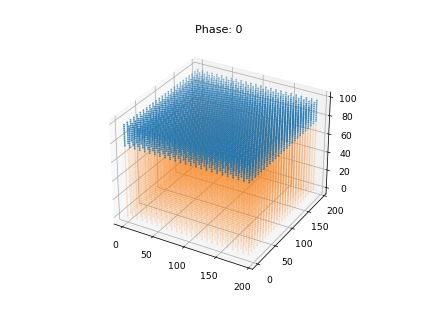

<IPython.core.display.Javascript object>


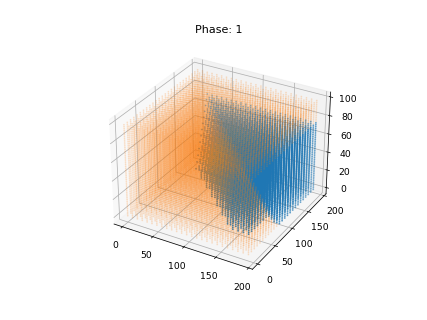

<IPython.core.display.Javascript object>


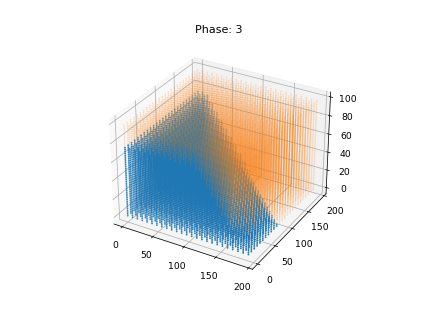

In [14]:
view_specimen(new_specimen3, sampling = (8,8,2))

In [15]:
#build a ledge into a second flat height

new_specimen4 = alter_below_plane(new_specimen3, (1,1,-1), (50,50,50), 0, 3)
new_specimen4 = alter_below_plane(new_specimen4, (0,0,1), (50,50,30), 3, 0)

<IPython.core.display.Javascript object>


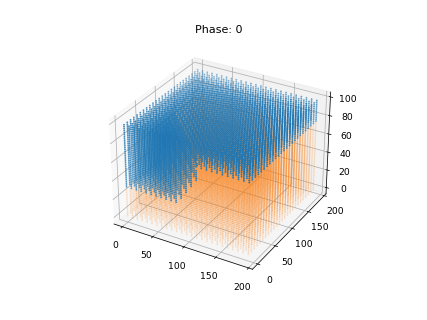

<IPython.core.display.Javascript object>


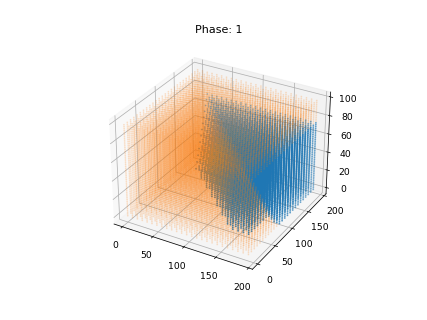

<IPython.core.display.Javascript object>


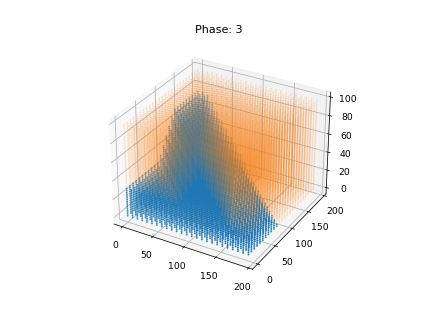

In [16]:
view_specimen(new_specimen4, sampling = (8,8,2))

## add some surface precipitates

As we will only put precipitates in air it probably makes more sense to define the desired number and then randomly generate a sufficent number of locations to get this

In [17]:
desired_expected_precip = 3
max_radius = 20
random_seed = 5
np.random.seed(random_seed)



air_fraction = np.where(new_specimen4 == 0,1,0).sum()/new_specimen4.size
air_cols = new_specimen4.shape[2]-np.argmin(new_specimen4, axis = -1)
prop_within_max_r_of_surface = np.mean((np.ones_like(air_cols)*max_radius)/air_cols)
prop_on_surface = 0.25*prop_within_max_r_of_surface

prop_of_eligable_precip = air_fraction*prop_on_surface

n_precip = int(np.ceil(desired_expected_precip/prop_of_eligable_precip)) #will end up getting 
print(n_precip)


##get some random centres within the scene
centres = np.random.random_sample((n_precip, 3), ) * np.array(specimen.shape)

##and some random radii
radii = np.random.random((n_precip))*max_radius

54


In [18]:
centres, radii

(array([[ 44.39863422, 174.14646124,  20.67191553],
        [183.72218159,  97.68223776,  61.17438629],
        [153.1815713 , 103.68359757,  29.68005016],
        [ 37.54424573,  16.14825375,  73.84402962],
        [ 88.26184458,  31.66197354,  87.99370312],
        [ 54.8172924 ,  82.84700382,  29.60799327],
        [125.75758178, 115.96756204,  59.99291966],
        [ 53.16382351,  56.93717613,  25.35882058],
        [ 65.51278954,  28.83286013,  16.56128612],
        [192.78610581, 192.04534306,  18.84146556],
        [  4.86131233,  40.91110928,  69.98436141],
        [155.90291711,   4.58661849,  57.76628581],
        [  0.32843454, 103.09452238,  63.97951761],
        [197.12488056,  51.81951928,  80.24968853],
        [174.0966174 , 184.54992279,   0.22142125],
        [ 93.89767435, 196.29374752,  39.89448039],
        [162.74649552, 109.29129959,  77.08540871],
        [ 96.986215  ,   5.82231273,   8.65256884],
        [ 22.29076248,  50.24902234,  96.49152925],
        [126

ensure no floating precipitates

In [19]:
centre_approx_locations = np.round(centres, 0).astype(int)

In [20]:
good_cent = []
good_rad = []

for c_ind, c in enumerate(centre_approx_locations):
    if new_specimen4[c[0], c[1], c[2]] == 0:
        d = c[2] - np.argmin(new_specimen4[c[0], c[1]])
        c_rad = radii[c_ind]
        if d <= c_rad:          
            print(d, c[2], c_rad)
            good_cent.append(c)
            good_rad.append(c_rad)
        

5 80 6.372928753646628
2 77 10.84180818154017
8 80 19.94450933125844
4 51 14.535787412671521
5 80 15.547639892570285
2 77 3.3128365327659304


In [21]:
specimen5 = copy.deepcopy(new_specimen4)
for sphere_i in range(len(good_cent)):
    if sphere_i%2 == 0:
        specimen5 = alter_within_sphere(specimen5, good_cent[sphere_i], good_rad[sphere_i], 2, [0,1,3])
    else:
        specimen5 = alter_within_sphere(specimen5, good_cent[sphere_i], good_rad[sphere_i], 4, [0,1,3])

<IPython.core.display.Javascript object>


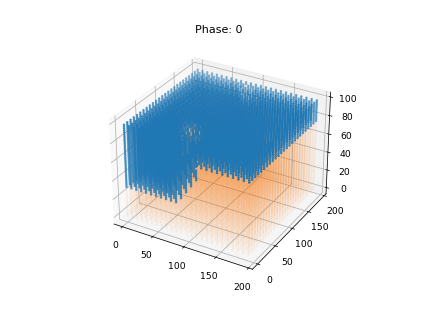

<IPython.core.display.Javascript object>


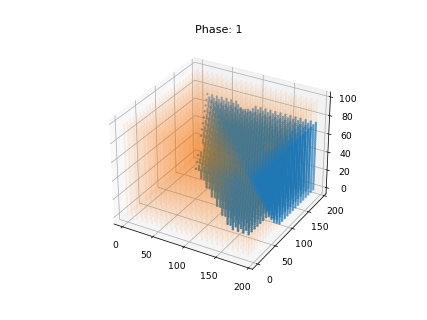

<IPython.core.display.Javascript object>


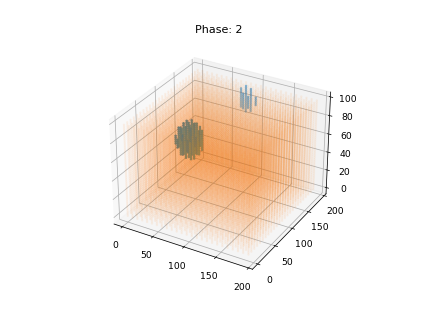

<IPython.core.display.Javascript object>


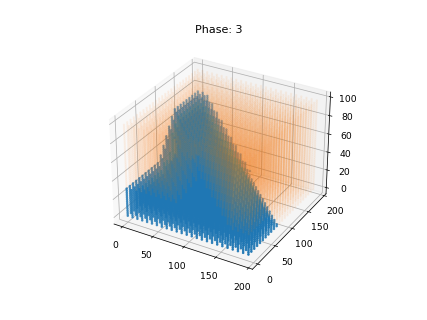

<IPython.core.display.Javascript object>


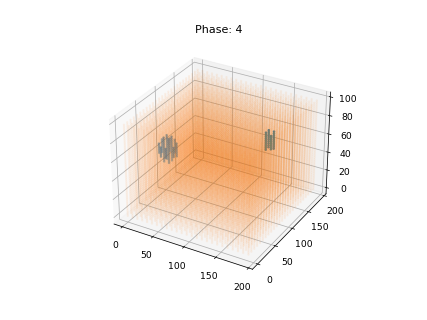

In [22]:
view_specimen(specimen5, sampling=(8,8,2), s = 3, alpha=0.05)

In [23]:
labelled_specimen, num_labels = specimen5, len(np.unique(specimen5))

In [24]:
num_labels

5

In [25]:
np.unique(labelled_specimen)

array([0, 1, 2, 3, 4])

In [26]:
labelled_specimen.shape

(200, 200, 100)

<IPython.core.display.Javascript object>


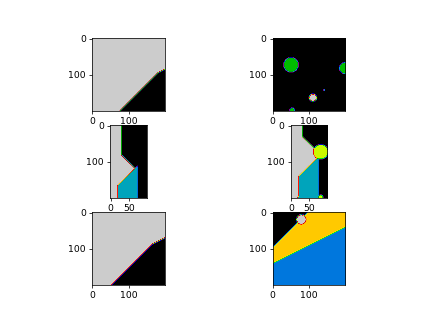

In [27]:
fig, ax = plt.subplots(3,2)
ax[0,0].imshow(labelled_specimen [:,:,0], cmap='nipy_spectral')
ax[0,1].imshow(labelled_specimen [:,:,80], cmap='nipy_spectral')
ax[1,0].imshow(labelled_specimen [:,0,:], cmap='nipy_spectral')
ax[1,1].imshow(labelled_specimen [:,50,:], cmap='nipy_spectral')
# ax[2,0].imshow(labelled_specimen [0,:,:], cmap='nipy_spectral')
# ax[2,1].imshow(labelled_specimen [-1,:,:], cmap='nipy_spectral')
ax[2,0].imshow(labelled_specimen [:,:,15], cmap='nipy_spectral')
ax[2,1].imshow(labelled_specimen [:,:,45], cmap='nipy_spectral')

In [28]:
phase1_num = np.where(labelled_specimen== 1,1,0).sum(axis = 2)
phase2_num = np.where(labelled_specimen== 2,1,0).sum(axis = 2)
phase3_num = np.where(labelled_specimen== 3,1,0).sum(axis = 2)
phase4_num = np.where(labelled_specimen== 4,1,0).sum(axis = 2)

In [29]:
from pathlib import Path

In [30]:
phase_path = '/dls/tmp/dto55534/SimulatedData'

In [31]:
np.save(phase_path+'/fcc110Au_sum.npy', phase1_num)
np.save(phase_path+'/Al2Cu_or1_sum.npy', phase2_num)
np.save(phase_path+'/fcc100Au_sum.npy', phase3_num)
np.save(phase_path+'/Al2Cu_or2_sum.npy', phase4_num)

<IPython.core.display.Javascript object>


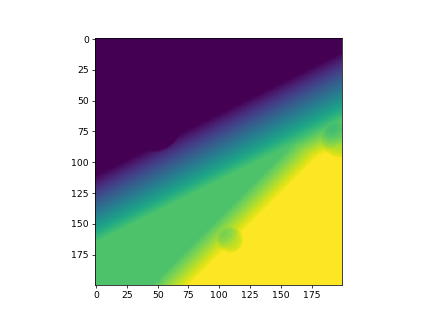

In [32]:
plt.figure()
plt.imshow(phase1_num)
plt.savefig(phase_path+'/fcc110Au_sum.jpg')

/tmp/ipykernel_42/43670482.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


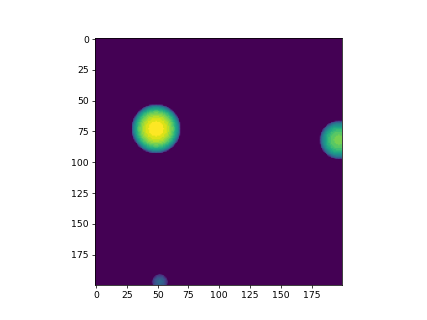

In [33]:
plt.figure()
plt.imshow(phase2_num)
plt.savefig(phase_path+'/Al2Cu_or1_sum.jpg')

<IPython.core.display.Javascript object>


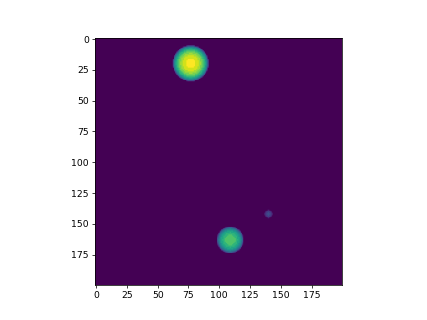

In [34]:
plt.figure()
plt.imshow(phase4_num)
plt.savefig(phase_path+'/Al2Cu_or2_sum.jpg')

<IPython.core.display.Javascript object>


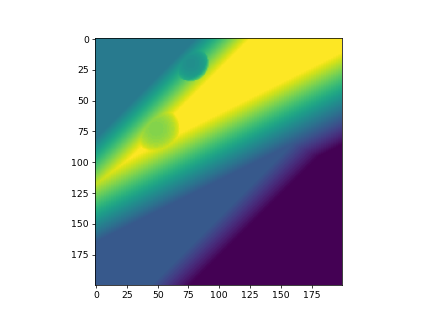

In [35]:
plt.figure()
plt.imshow(phase3_num)
plt.savefig(phase_path+'/fcc100Au_sum.jpg')

In [36]:
phase_proportion = phase1_num/(phase1_num+phase3_num)

<IPython.core.display.Javascript object>


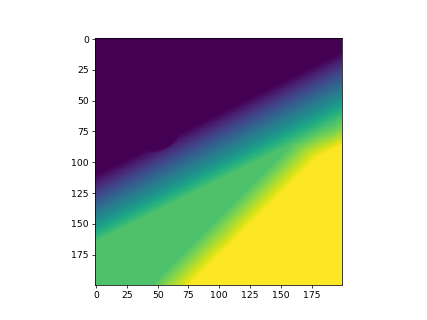

In [37]:
plt.figure()
plt.imshow(phase_proportion)

In [38]:
abtem.__version__

'1.0.0beta33'

In [39]:
from mp_api.client import MPRester
from pymatgen.io.ase import AseAtomsAdaptor

with MPRester("M0Obz6wJ54K7RPRwuqn1K7wmJsasBDfn") as mpr:
    docs = mpr.summary.search(material_ids=["mp-134"], fields=["structure"])
    al = AseAtomsAdaptor().get_atoms(docs[0].structure)
    
    docs2 = mpr.summary.search(material_ids=["mp-985806"], fields=["structure"])
    al2cu = AseAtomsAdaptor().get_atoms(docs2[0].structure)

/dls_sw/apps/python/miniforge/4.10.0-0/envs/epsic3.10/lib/python3.10/site-packages/mp_api/client/mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
# view(al, viewer='nglview')
# show_atoms(al);


In [41]:
# show_atoms(al2cu);


## This bit is for if you need to create a large rotated bulk of atoms, just so you can quickly check that you've created a bulk that covers the entire sample area

In [42]:
cube_corners = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], ])

In [43]:
cube_corners

array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [0, 1, 1]])

In [44]:
cube_corners * np.array((200,200,100))

array([[  0,   0,   0],
       [200,   0,   0],
       [200, 200,   0],
       [  0, 200,   0],
       [  0,   0, 100],
       [200,   0, 100],
       [200, 200, 100],
       [  0, 200, 100]])

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull



def show_extent(pts, cube_size):
    cube_corners = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], ]) * np.array(cube_size)
    
    
    cube_hull = ConvexHull(cube_corners)

    hull = ConvexHull(pts)
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection="3d")

    # Plot defining corner points
    #ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

    # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")
    
    for s in cube_hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(cube_corners[s, 0], cube_corners[s, 1], cube_corners[s, 2], "b-")

    # Make axis label
    for i in ["x", "y", "z"]:
        eval("ax.set_{:s}label('{:s}')".format(i, i))

    plt.show()

In [46]:
ppt1 = al2cu.repeat((100,80,100))
ppt1.translate([0,0,100])
ppt1.rotate(30, 'x')

ppt1.positions

array([[  0.        , -50.        ,  86.60254038],
       [  0.        , -47.2265074 ,  85.85938528],
       [  1.425547  , -48.98483159,  84.84421662],
       ...,
       [225.236426  , 280.04556583,  -1.83290245],
       [225.236426  , 282.81905843,  -2.57605755],
       [226.661973  , 281.06073424,  -3.59122621]])

<IPython.core.display.Javascript object>


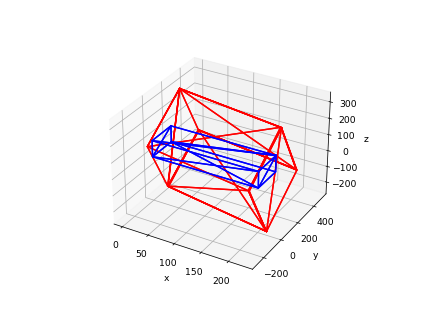

In [47]:
show_extent(ppt1.positions, (200,200,100))

Blue cubeoid is our sample region - can see it is entirely within the red cuboid which is the bulk structure that will be sampled from

In [48]:
# ppt1.translate([0,0,20])

In [49]:
 # Get all the postive positions!
# ppt2 = ppt1[[all(ppt1.positions[i,:]) for i in range(ppt1.positions.shape[0])]]
ppt2 = ppt1[[ppt1.positions[i,0] > 0 for i in range(ppt1.positions.shape[0])]]
ppt2_y = ppt2[[ppt2.positions[i,1] > 0 for i in range(ppt2.positions.shape[0])]]
ppt2_z = ppt2_y[[ppt2_y.positions[i,2] > 0 for i in range(ppt2_y.positions.shape[0])]]

In [50]:
ppt2_z.positions.shape

(1116915, 3)

set all atoms within the regions of voxels with label 2 to be this rotated al2cu phase

In [51]:
# gr2 = fcc100('Al', size=(100,100,20))
# gr2.translate([-100., 0 , 0])
ppt2_pos_int = ppt2_z.positions.astype(int)
label = 2
mask_atoms = np.zeros(ppt2_pos_int.shape[0], dtype=bool)
for _ in np.arange(ppt2_pos_int.shape[0]):
    if ppt2_pos_int[_,0] < labelled_specimen.shape[0]:
        if ppt2_pos_int[_,1] < labelled_specimen.shape[1]:
            if ppt2_pos_int[_,2] < labelled_specimen.shape[2]:
                if labelled_specimen[ppt2_pos_int[_,0], ppt2_pos_int[_,1], ppt2_pos_int[_,2]] == label:
                    mask_atoms[_] = 1
ppt_label_3 = ppt2_z[mask_atoms]

<IPython.core.display.Javascript object>


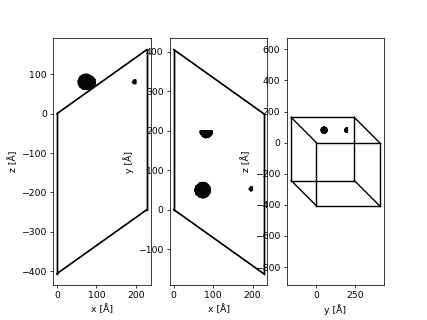

<Axes: xlabel='y [Å]', ylabel='z [Å]'>

In [52]:
fig, axs = plt.subplots(1,3)

abtem.show_atoms(ppt_label_3, plane='xz', ax=axs[0])
abtem.show_atoms(ppt_label_3, plane='xy', ax=axs[1])
abtem.show_atoms(ppt_label_3, plane='yz', ax=axs[2])

<IPython.core.display.Javascript object>


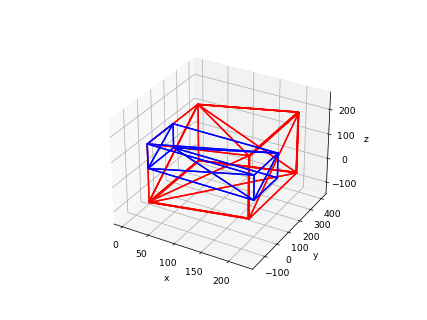

In [53]:
ppt1 = al2cu.repeat((100,80,60))
ppt1.translate([0,0,100])
#ppt1.rotate(30, 'x')

ppt1.positions

show_extent(ppt1.positions, (200,200,100))

In [54]:
# ppt1.translate([0,0,20])

In [55]:
 # Get all the postive positions!
# ppt2 = ppt1[[all(ppt1.positions[i,:]) for i in range(ppt1.positions.shape[0])]]
ppt2 = ppt1[[ppt1.positions[i,0] > 0 for i in range(ppt1.positions.shape[0])]]
ppt2_y = ppt2[[ppt2.positions[i,1] > 0 for i in range(ppt2.positions.shape[0])]]
ppt2_z = ppt2_y[[ppt2_y.positions[i,2] > 0 for i in range(ppt2_y.positions.shape[0])]]

In [56]:
ppt2_z.positions.shape

(813085, 3)

All label 4 to this unrotated al2cu phase

In [57]:
# gr2 = fcc100('Al', size=(100,100,20))
# gr2.translate([-100., 0 , 0])
ppt2_pos_int = ppt2_z.positions.astype(int)
label = 4
mask_atoms = np.zeros(ppt2_pos_int.shape[0], dtype=bool)
for _ in np.arange(ppt2_pos_int.shape[0]):
    if ppt2_pos_int[_,0] < labelled_specimen.shape[0]:
        if ppt2_pos_int[_,1] < labelled_specimen.shape[1]:
            if ppt2_pos_int[_,2] < labelled_specimen.shape[2]:
                if labelled_specimen[ppt2_pos_int[_,0], ppt2_pos_int[_,1], ppt2_pos_int[_,2]] == label:
                    mask_atoms[_] = 1
ppt_label1 = ppt2_z[mask_atoms]

<IPython.core.display.Javascript object>


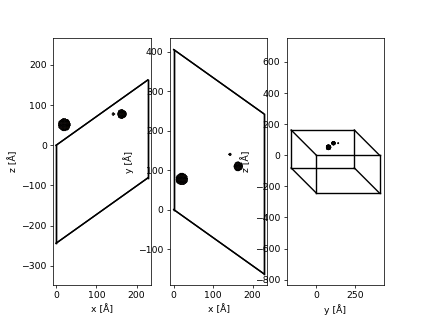

<Axes: xlabel='y [Å]', ylabel='z [Å]'>

In [58]:
fig, axs = plt.subplots(1,3)

abtem.show_atoms(ppt_label1, plane='xz', ax=axs[0])
abtem.show_atoms(ppt_label1, plane='xy', ax=axs[1])
abtem.show_atoms(ppt_label1, plane='yz', ax=axs[2])

label 1 -> fcc110 Au and label 3 -> fcc100 Au

In [59]:
gr1 = fcc110('Au', size=(200,200,100))
gr1_pos_int = gr1.positions.astype(int)
label = 1
mask_atoms = np.zeros(gr1_pos_int.shape[0], dtype=bool)
for _ in np.arange(gr1_pos_int.shape[0]):
    if gr1_pos_int[_,0] < labelled_specimen.shape[0]:
        if gr1_pos_int[_,1] < labelled_specimen.shape[1]:
            if gr1_pos_int[_,2] < labelled_specimen.shape[2]:
                if labelled_specimen[gr1_pos_int[_,0], gr1_pos_int[_,1], gr1_pos_int[_,2]] == label:
                    mask_atoms[_] = 1
gr1_mod = gr1[mask_atoms]


gr2 = fcc100('Au', size=(200,200,100))
# gr2.translate([-100., 0 , 0])
gr2_pos_int = gr2.positions.astype(int)
label = 3
mask_atoms = np.zeros(gr2_pos_int.shape[0], dtype=bool)
for _ in np.arange(gr2_pos_int.shape[0]):
    if gr2_pos_int[_,0] < labelled_specimen.shape[0]:
        if gr2_pos_int[_,1] < labelled_specimen.shape[1]:
            if gr2_pos_int[_,2] < labelled_specimen.shape[2]:
                if labelled_specimen[gr2_pos_int[_,0], gr2_pos_int[_,1], gr2_pos_int[_,2]] == label:
                    mask_atoms[_] = 1
gr2_mod = gr2[mask_atoms]

combine all together into one atomic model

In [60]:
sample_model = gr2_mod + gr1_mod + ppt_label1 + ppt_label_3

<IPython.core.display.Javascript object>


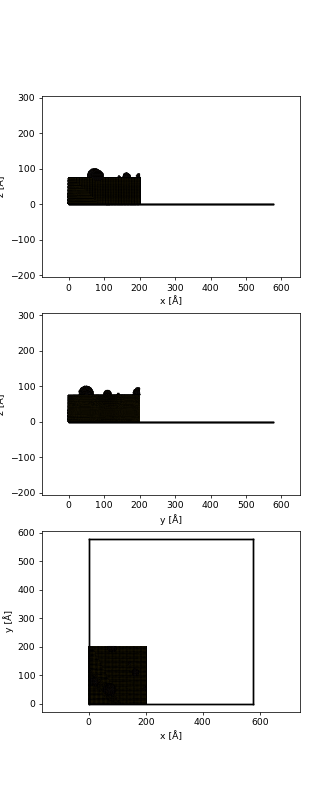

<Axes: xlabel='x [Å]', ylabel='y [Å]'>

In [61]:
fig, axs = plt.subplots(3,1, figsize = (5, 12))
abtem.show_atoms(sample_model, plane = 'xz', ax=axs[0])
abtem.show_atoms(sample_model, plane = 'yz', ax=axs[1])
abtem.show_atoms(sample_model, plane = 'xy', ax=axs[2])

In [62]:
fig = plt.gcf()
size = fig.get_size_inches()
size

array([ 5., 12.])

In [63]:
pwd

'/home/dto55534/Documents/DPhil/SEND_data_production'

In [64]:
import ase

In [65]:
type(sample_model)

ase.atoms.Atoms

ase.io.write("./model.xyz", sample_model)

## Make 4DSTEM data

In [66]:
np.max(np.asanyarray(sample_model.positions))

199.92000000000002

In [67]:
sample_model.cell = [200, 200, 100]

In [68]:
potential = abtem.Potential(
    sample_model,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
    device = 'gpu'
)

In [69]:
probe = abtem.Probe(
    energy=300e3,
    semiangle_cutoff=1.5)
probe.grid.match(potential)

In [70]:
intensity = probe.build()



<IPython.core.display.Javascript object>


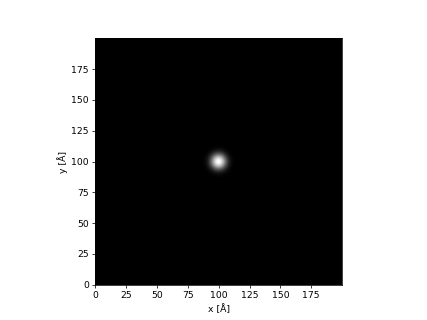

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f8cf76cf880>)

In [71]:
intensity.show()

In [70]:
scan_start = [20.0, 20.0]
scan_end = [180.0, 180.0]

In [71]:
scan_start_arr = np.asarray(scan_start)
scan_end_arr = np.asarray(scan_end)

In [72]:
#assuming cubic cell
cell_a = sample_model.cell[0][0]
cell_b = sample_model.cell[1][1]

In [73]:
scan_start_frac = scan_start_arr/np.array((cell_a, cell_b))
scan_end_frac = scan_end_arr/np.array((cell_a, cell_b))

In [76]:
# grid_scan = abtem.GridScan.from_fractional_coordinates(
#     potential,
#     start=[0, 0],
#     end=[1 / 3, 1 / 2],
#     sampling=probe.aperture.nyquist_sampling,
# )

gridscan = abtem.GridScan(start=scan_start, end=scan_end, sampling=[2.0, 2.0])

In [77]:
ax, im = potential.project().show();

gridscan.add_to_mpl_plot(ax)

RuntimeError: CuPy is not installed, only CPU calculations available

In [92]:
probe.antialias_aperture

(0.6666666666666666, 0.6666666666666666)

In [93]:
probe.cutoff_scattering_angles

(131.2171135033549, 131.2171135033549)

<IPython.core.display.Javascript object>


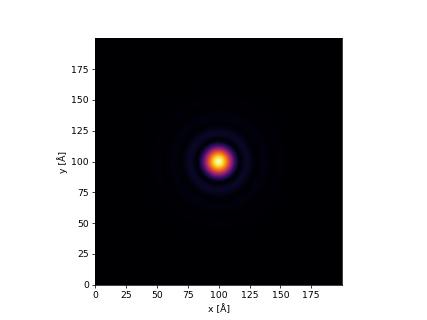

In [94]:
probe.show(cmap='inferno', power=.3);

In [95]:
from abtem.detect import PixelatedDetector

pixelated_detector = PixelatedDetector(max_angle=50.0)

In [ ]:
pixelated_measurement = probe.scan(gridscan, pixelated_detector, potential)

Potential:   0%|          | 0/100 [00:00<?, ?it/s]

Scan:   0%|          | 0/6400 [00:00<?, ?it/s]

In [ ]:
pixelated_measurement.write('/dls/tmp/dto55534/au_al2cu_dual_precip.hdf5')

In [78]:
import h5py

In [ ]:
with h5py.File('/dls/tmp/dto55534/au_al2cu_dual_precip.hdf5', 'r') as f:
    pix_data = f['array'][()]

In [ ]:
d = hs.signals.Signal2D(pix_data)

In [ ]:
d

In [ ]:
d.plot(vmax='90th')

In [45]:
dose = 1e8
factor = dose / np.sum(d.data)

data_highD = factor * d.data
data_highD = np.random.poisson(data_highD)

<IPython.core.display.Javascript object>


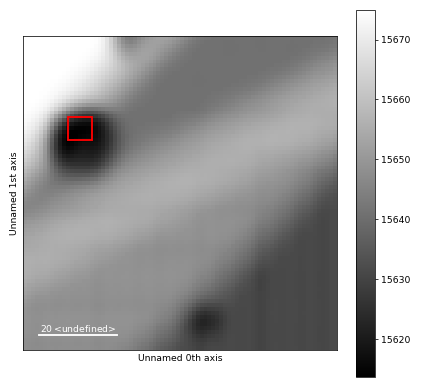

<IPython.core.display.Javascript object>


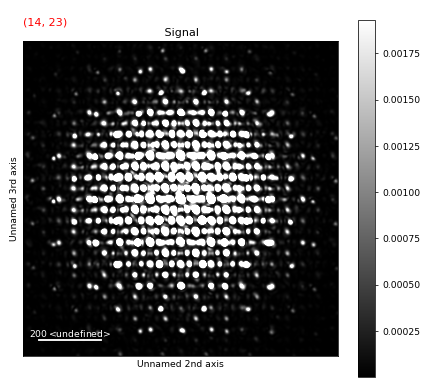

In [46]:
d.plot(vmax='90th')

In [ ]:
poisson_noise = np.random.poisson(size = d.data.shape)

In [81]:
data_highD = hs.signals.Signal2D(data_highD)

<IPython.core.display.Javascript object>


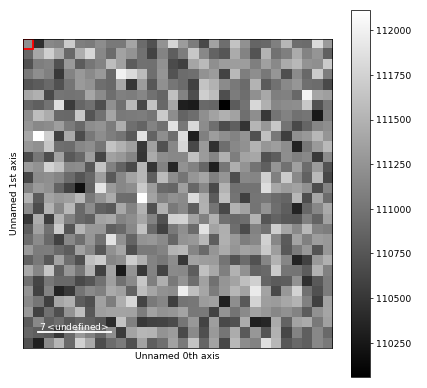

<IPython.core.display.Javascript object>


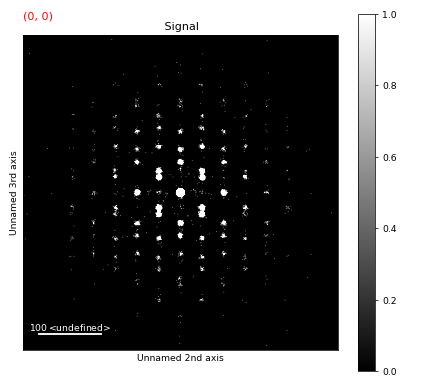

In [82]:
data_highD.plot(vmax='99th')

In [80]:
data_highD = hs.load('/dls/tmp/dto55534/au_al2cu_dual_sim_dataset.hspy')

<IPython.core.display.Javascript object>


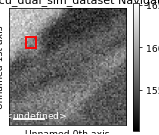

<IPython.core.display.Javascript object>


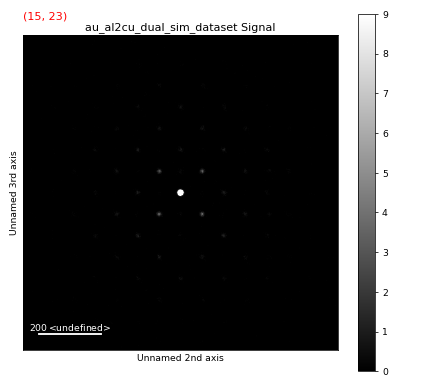

In [81]:
data_highD.plot()

In [169]:
pwd

'/dls/science/groups/e02/Mohsen/code/jupyterhub_active/ASE_model'

### Adding in the EDX simulation

In [74]:
start_img_coord, end_img_coord = ((scan_start_frac*np.array(labelled_specimen.shape[0:2])).astype('int'),  
                                  (scan_end_frac*np.array(labelled_specimen.shape[0:2])).astype('int'))

In [75]:
scan_area_specimen = labelled_specimen[start_img_coord[0]:end_img_coord[0], 
                                       start_img_coord[1]: end_img_coord[1] ]

In [76]:
scan_area_specimen.shape

(160, 160, 100)

In [77]:
test_area = scan_area_specimen[:,:,0]

In [78]:
from skimage.transform import resize

In [82]:
scan_resize = data_highD.data.shape[:2]

In [83]:
phase_maps = []
for uind in np.unique(scan_area_specimen):
    phase_map = np.where(scan_area_specimen == uind,1,0)
    scanned_phase_map = np.moveaxis([resize(layer.astype('float'), scan_resize) 
                        for layer in np.moveaxis(phase_map, -1, 0)],0, -1)
        
    
    phase_maps.append(scanned_phase_map)

In [84]:
phase_maps[0].shape

(80, 80, 100)

In [85]:
test_phase_map = phase_maps[0]

In [86]:
phase_map_coords = np.asarray(np.where(test_phase_map != -1)).T

In [87]:
flat_phase_map = test_phase_map.reshape((test_phase_map.shape[0]*test_phase_map.shape[1]*test_phase_map.shape[2]))

<IPython.core.display.Javascript object>


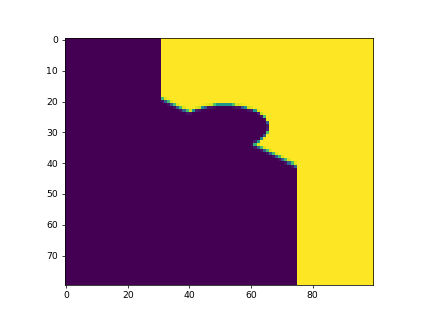

In [88]:
plt.figure()
plt.imshow(test_phase_map[1])

<IPython.core.display.Javascript object>


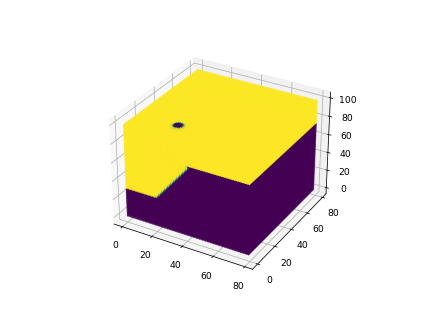

In [89]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(phase_map_coords[:,0], phase_map_coords[:,1], phase_map_coords[:,2], c = flat_phase_map, s = 1)

In [90]:
prop_phase_maps = [np.mean(pm, axis = -1) for pm in phase_maps]

<IPython.core.display.Javascript object>


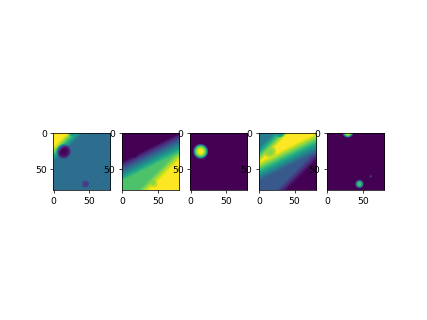

In [91]:
fig,ax = plt.subplots(1, len(prop_phase_maps))
for i, ppm in enumerate(prop_phase_maps):
    ax[i].imshow(ppm)

!pip install espm

In [96]:
# espm imports
from espm.datasets.base import generate_dataset
from espm.weights.generate_weights import chemical_map_weights
from espm.models.generate_EDXS_phases import generate_modular_phases
from espm.models.EDXS_function import elts_list_from_dict_list

# Generic imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs

In [97]:
def get_repo_path():
    """Get the path to the git repository.

    This is a bit of a hack, but it works.
    """
    this_path = Path.cwd() / Path("generate_data.ipynb")
    return this_path.resolve().parent.parent

# Path of the experimental dataset
path = Path("/dls/tmp/dto55534/espm/generated_data/71GPa_experimental_data.hspy")

In [98]:
weights = np.moveaxis(np.asarray(prop_phase_maps), 0 , -1)[:,:,1:]

In [99]:
weights = weights/weights.sum(axis = 2)[:,:,None]

<IPython.core.display.Javascript object>


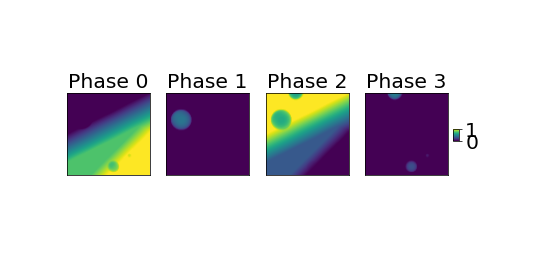

In [116]:
fig,axs = plt.subplots(1,4,figsize = (8,4))
for j in range(axs.shape[0]) :
    im = axs[j].imshow(weights[:,:,j],vmin = 0, vmax = 1.0)
    axs[j].tick_params(axis = "both",width = 0,labelbottom = False,labelleft = False)
    axs[j].set_title("Phase {}".format(j),fontsize = 22)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.47, 0.01, 0.045])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.tick_params(labelsize=22)

In [119]:
# Elemental concetration of each phase
elts_dicts = [
    # FCC Gold
    {
        "Au" : 1.0
    },
    # Al2Cu
    {
        "Al" : 0.666, "Cu" : 0.333
    },
    {
        "Au" : 1.0
    },
    # Al2Cu
    {
        "Al" : 0.666, "Cu" : 0.333
    },]

# Parameters of the bremsstrahlung
brstlg_pars = [
    {"b0" : 0.0007853, "b1" : 0.0003658},
    {"b0" : 0.0001629, "b1" : 0.0009812},
    {"b0" : 0.0007853, "b1" : 0.0003658},
    {"b0" : 0.0003458, "b1" : 0.0006268}
]

# Model parameters : energy scale, detector broadening, x-ray emission database, beam energy, absorption parameters, detector efficiency
model_params = {
        "e_offset" : 0.3,
        "e_size" : 1024,
        "e_scale" : 0.01,
        "width_slope" : 0.01,
        "width_intercept" : 0.065,
        "db_name" : "default_xrays.json",
        "E0" : 200,
        "params_dict" : {
            "Abs" : {
                "thickness" : 100.0e-7,
                "toa" : 35,
                "density" : 4.5,
                "atomic_fraction" : False
            },
            "Det" : "SDD_efficiency.txt"
        }
    }

# miscellaneous paramaters : average detected number of X-rays per pixel, phases densities, output folder, model name, random seed
data_dict = {
    "N" : 100,
    "densities" : [1.0,1.0,1.0,1.0],
    "data_folder" : "71GPa_synthetic_N100",
    "model" : "EDXS",
    "seed" : 42
}

In [120]:
phases = generate_modular_phases(
    elts_dicts=elts_dicts, brstlg_pars = brstlg_pars,
    scales = [1, 1, 1,1],
    model_params= model_params,
    seed = 42
    )
# scales : bremsstrahlung parameters modifiers

elements = elts_list_from_dict_list(elts_dicts)

<IPython.core.display.Javascript object>


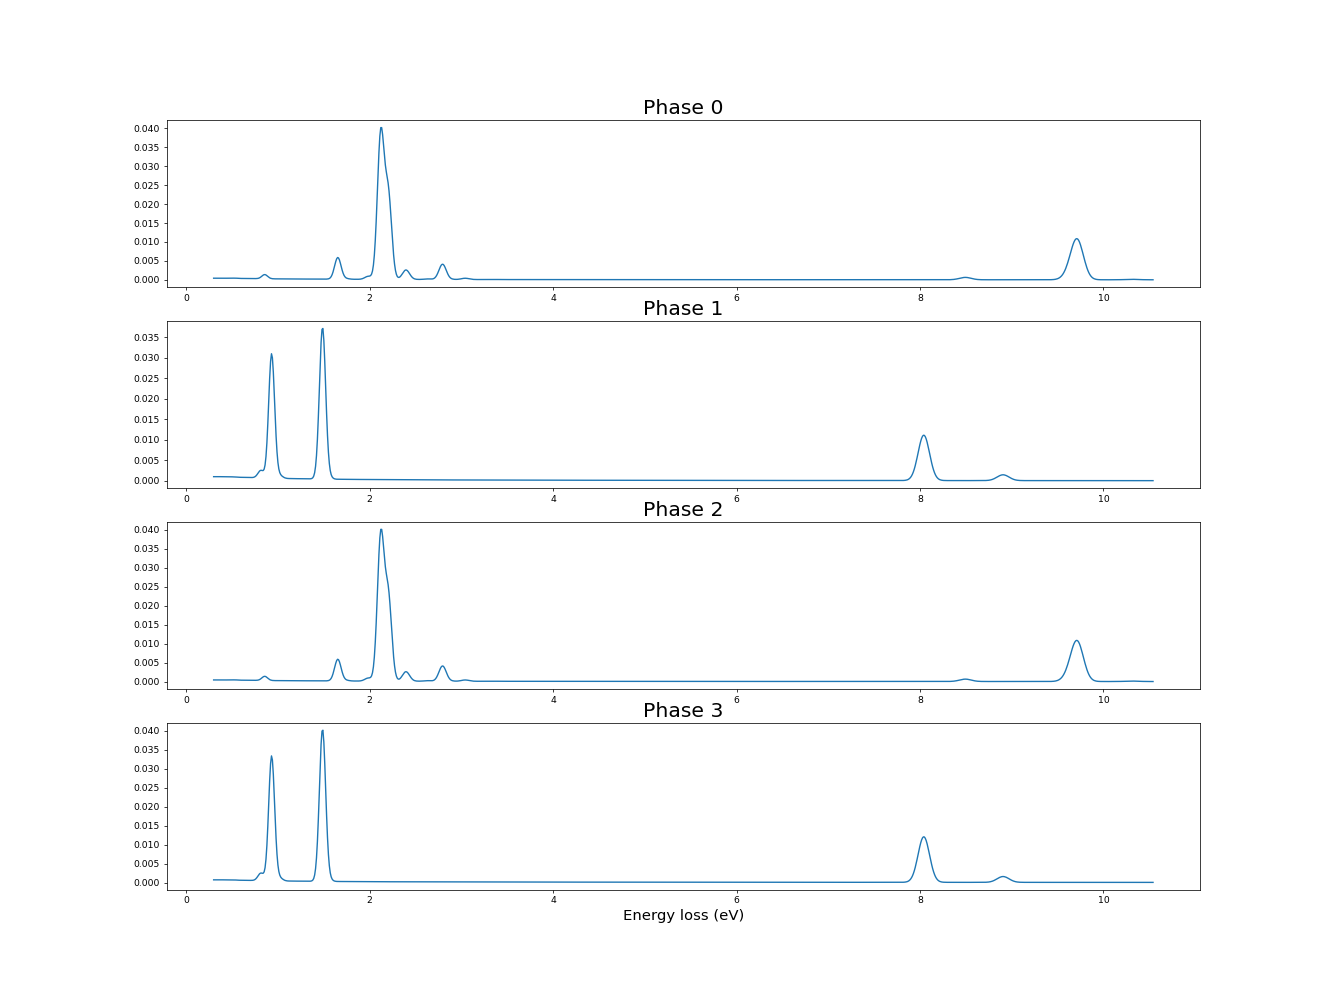

Text(0.5, 0, 'Energy loss (eV)')

In [121]:
fig,axs = plt.subplots(4,1,figsize = (20,15))

# Build the energy scale
x = np.linspace(
    model_params["e_offset"],
    model_params["e_offset"]+model_params["e_scale"]*model_params["e_size"],
    num=model_params["e_size"])

for j in range(axs.shape[0]) :
    axs[j].plot(x,phases[j])
    axs[j].set_title("Phase {}".format(j),fontsize = 22)

axs[-1].set_xlabel("Energy loss (eV)",fontsize = 16)

In [122]:
generate_dataset( phases = phases,
                  weights = weights,
                  model_params = model_params,
                  misc_params = data_dict,
                  base_seed=data_dict["seed"],
                  sample_number=2,
                  elements = elements,
                base_path = Path('/dls/tmp/dto55534/espm/generated_data'))

  0%|          | 0/2 [00:00<?, ?it/s]

Overwrite '/dls/tmp/dto55534/espm/generated_data/71GPa_synthetic_N100/sample_0.hspy' (y/n)?
y


 50%|█████     | 1/2 [00:03<00:03,  3.05s/it]

Overwrite '/dls/tmp/dto55534/espm/generated_data/71GPa_synthetic_N100/sample_1.hspy' (y/n)?
y


100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


In [123]:
eds_sig = hs.load('/dls/tmp/dto55534/espm/generated_data/71GPa_synthetic_N100/sample_1.hspy')

<IPython.core.display.Javascript object>


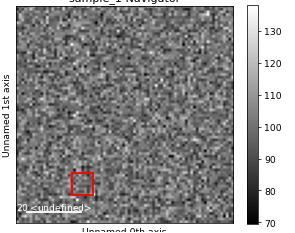

<IPython.core.display.Javascript object>


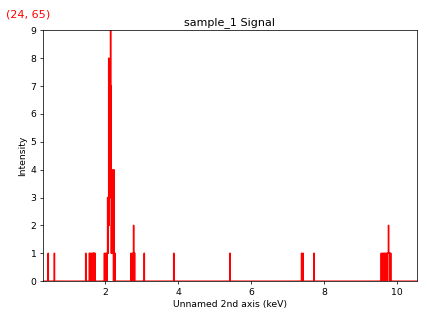

In [124]:
eds_sig.plot()